## Anaysis of firn thickness and its dependence on accumulatin rate, temperature and grain size. 
Skin temperature, grain size and accumulaiton come from RACMO (courtesy of Melchior van Wessem, pers comm). 

Grain size RACMO output is stored in the netcdf reffsnw_yearlyA_ANT27_ERA5-3H_RACMO2.3p2_1979_2019.nc included in this repo. 

Skin temperature and accumulaiton rate are stored in a zarr directory: gs://pangeo-pgc/tskin_snowmelt_precip6

Firn densities come from the SUMup dataset: https://arcticdata.io/catalog/view/urn%3Auuid%3A3808bab2-6a34-4ad0-bb35-b97d353750e0

# 1. load packages, download data

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
from pyproj import CRS 
from pyproj import Transformer 

### if you need to, download the SUMup dataset

In [3]:
#!wget --content-disposition https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A3808bab2-6a34-4ad0-bb35-b97d353750e0
#!wget --content-disposition   https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A9172151f-3b5d-4885-8302-3e057f698f68

# 2. load time-averaged RACMO output and extract coord reference system info
(see consolidate consolidate_RACMO.ipynb for how this is created). 

In [11]:
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')
pTsg = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/RACMO/pTsg.zarr'))
pTsg


<xarray.Dataset>
Dimensions:       (rlat: 240, rlon: 262)
Coordinates:
    height        float64 ...
    lat           (rlat, rlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>
  * rlat          (rlat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75
  * rlon          (rlon) float64 -32.75 -32.5 -32.25 -32.0 ... 32.0 32.25 32.5
Data variables:
    assigned      float64 ...
    dir           (rlat, rlon) float64 dask.array<chunksize=(120, 262), meta=np.ndarray>
    precip        (rlat, rlon) float32 dask.array<chunksize=(240, 262), meta=np.ndarray>
    reffsnw       (rlat, rlon) float32 dask.array<chunksize=(240, 262), meta=np.ndarray>
    rotated_pole  float32 ...
    snowmelt      (rlat, rlon) float32 dask.array<chunksize=(240, 262), meta=np.ndarray>
    tskin         (rlat, rlon) float32 dask.array<chunksize=(240, 262), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    CreationDate:  Tue Dec 20 03:35:37 2016
    Domain:        ANT27
    Experiment:    ERAINx_RACMO2.4.1
    comment:       asim2cdf: cpar=tskin, iwmo=11, ilvt=105, ilev=0, idh=3, ih...
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    source:        RACMO2
    title:         time averaged precipitation, tskin, grain size and snowmelt

### Use pyproj to define a transformer object with the info from the RACMO nc

In [12]:
# define the rotated pole coordinate reference system (crs)
crs_rotatedPole = CRS.from_proj4(pTsg.rotated_pole.attrs['proj4_params'])
# define the WGS84 crs (the standard one used widely)
crs_4326 = CRS.from_epsg(4326)
# define the 'transformer' object, which can convert from WGS84 to the rotated pole RACMO crs.
tr = Transformer.from_crs(crs_4326, crs_rotatedPole)

Note that rotated pole crs expects lonitude first, while WGS84 expects latitiude first. 

In [13]:
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
crs_rotatedPole

<Geographic 2D CRS: +proj=ob_tran -m 57.295779506 +o_proj=latlon +o_la ...>
Name: unnamed
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: PROJ ob_tran o_proj=latlon
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### To test the conversion we can compare the values of RACMO.lat and RACMO.lon with RACMO.rlat and RACMO.rlon in some random places. 

In [15]:
# pick a pair of indexes
rLatI = 50
rLonI = 150

# find the latitude and longitude of this grid point 
lat = pTsg.lat[rLatI,rLonI].values
lon = pTsg.lon[rLatI,rLonI].values

# find the rotated lat and rotated lon of this grid point
rlat = pTsg.rlat[rLatI].values
rlon = pTsg.rlon[rLonI].values

# convert lat and lon to rlat and rlon and check that we are doing it correctly

rlon2, rlat2 = tr.transform(lat,lon)    # note the order is the order of the first crs in the transformer (WGS84 in this case)

np.array(rlat2)-rlat, np.array(rlon2)-rlon    # the difference is small, indicating that the conversion is working well. 

(-2.0107603759811354e-07, 2.0915067278082233e-07)

## wrap the transform object in a function for use later


In [16]:
def tr_lat(lat,lon):
    rlon,  rlat = tr.transform(np.array(lat),np.array(lon))
    return  rlat
def tr_lon(lat,lon):
    rlon,  rlat = tr.transform(np.array(lat),np.array(lon))
    return  rlon

# 3. Firn density data
### load and subset the firn core database
This database comes as a list of all depth density measurements. Many of the cores did not reach the bubble-close-off depth where \rho = 830 kg m-3, so we cut those out leaving only a subset of the data

In [17]:
# load the SUMup data
SUMup = pd.read_csv('SUMup_datasets_july2018_density.csv')
# remove most of the columns
SUMup = SUMup[["lat" , "lon", "midpoint_depth","density"]]
print("# of rows before subsetting: {}".format(len(SUMup)))
# remove the data from cores that did not reach the bubble-close-off depth and remove all the data from the northern hemisphere
SUMup  = SUMup.groupby("lat").filter(lambda x: max(x["density"]) > 0.83 * max(x["lat"]) < 0)
print("# of rows after subsetting: {}".format(len(SUMup)))


# of rows before subsetting: 2168928
# of rows after subsetting: 519017


### add two new colums to SUMup with the rotated lats and lons
this calls the two functions defined above, which contain the transform object. 

In [18]:
SUMup["rlat"] = tr_lat(SUMup["lat"], SUMup["lon"])
SUMup["rlon"] = tr_lon(SUMup["lat"], SUMup["lon"])
SUMup

,lat,lon,midpoint_depth,density,rlat,rlon
0,-80.7901,124.4345,0.045000,0.420000,-3.796092,8.397339
1,-80.7901,124.4345,0.075000,0.480000,-3.796092,8.397339
2,-80.7901,124.4345,0.105000,0.440000,-3.796092,8.397339
3,-80.7901,124.4345,0.135000,0.390000,-3.796092,8.397339
4,-80.7901,124.4345,0.165000,0.400000,-3.796092,8.397339
...,...,...,...,...,...,...
1307264,-75.0100,0.0800,1.991897,0.369950,14.760753,-2.641078
1307265,-75.0100,0.0800,1.992024,0.370790,14.760753,-2.641078
1307266,-75.0100,0.0800,1.992152,0.370954,14.760753,-2.641078
1307267,-75.0100,0.0800,1.992279,0.370644,14.760753,-2.641078


## start a cluster to do the interpolation step


In [24]:
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()
cluster = gateway.new_cluster()


In [25]:
cluster.scale(24)
client = Client(cluster)
cluster

### interpolate tskin, precip and grain size, at the rlats and rlons of the SUMup data points

use advanced interpolation http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation

In [26]:
# make two dataarrays from the rlat and rlon columns in the SUMup dataframe
rlat_XR = xr.DataArray(np.array(SUMup.rlat), dims="SUMup_entry_num",attrs = {'long_name' :'latitude in rotated pole grid'})
rlon_XR = xr.DataArray(np.array(SUMup.rlon), dims="SUMup_entry_num",attrs = {'long_name' : "longitude in rotated pole grid"})

perform the interpolation

In [30]:
b_SUMup_XR = pTsg.precip.interp(rlat=rlat_XR, rlon=rlon_XR).compute()
tskin_SUMup_XR = pTsg.tskin.interp(rlat=rlat_XR, rlon=rlon_XR).compute()
g_SUMup_XR = pTsg.reffsnw.interp(rlat=rlat_XR, rlon=rlon_XR).compute()

In [31]:
tskin_SUMup_XR

<xarray.DataArray 'tskin' (SUMup_entry_num: 519017)>
array([224.33480022, 224.33480022, 224.33480022, ..., 230.29009945,
       230.29009945, 230.29009945])
Coordinates:
    height   float64 0.0
    lat      (SUMup_entry_num) float64 -80.79 -80.79 -80.79 ... -75.01 -75.01
    lon      (SUMup_entry_num) float64 124.4 124.4 124.4 ... 0.08054 0.08054
    rlat     (SUMup_entry_num) float64 -3.796 -3.796 -3.796 ... 14.76 14.76
    rlon     (SUMup_entry_num) float64 8.397 8.397 8.397 ... -2.641 -2.641
Dimensions without coordinates: SUMup_entry_num
Attributes:
    cell_methods:   time: mean over whole simulation
    grid_mapping:   rotated_pole
    long_name:      Skin temperature
    standard_name:  t_skin
    units:          K

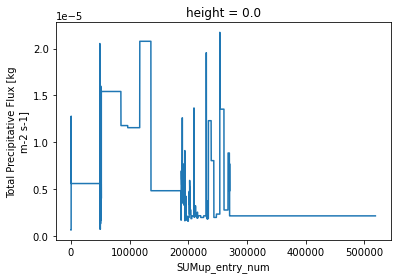

In [32]:
b_SUMup_XR.plot()

In [41]:
cluster.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [33]:
SUMup["b"]     = b_SUMup_XR.to_pandas().values
SUMup["tskin"] = tskin_SUMup_XR.to_pandas().values
SUMup["grain_size"] = g_SUMup_XR.to_pandas().values

SUMup

,lat,lon,midpoint_depth,density,rlat,rlon,b,tskin,grain_size
0,-80.7901,124.4345,0.045000,0.420000,-3.796092,8.397339,6.530366e-07,224.334800,0.000239
1,-80.7901,124.4345,0.075000,0.480000,-3.796092,8.397339,6.530366e-07,224.334800,0.000239
2,-80.7901,124.4345,0.105000,0.440000,-3.796092,8.397339,6.530366e-07,224.334800,0.000239
3,-80.7901,124.4345,0.135000,0.390000,-3.796092,8.397339,6.530366e-07,224.334800,0.000239
4,-80.7901,124.4345,0.165000,0.400000,-3.796092,8.397339,6.530366e-07,224.334800,0.000239
...,...,...,...,...,...,...,...,...,...
1307264,-75.0100,0.0800,1.991897,0.369950,14.760753,-2.641078,2.158727e-06,230.290099,0.000230
1307265,-75.0100,0.0800,1.992024,0.370790,14.760753,-2.641078,2.158727e-06,230.290099,0.000230
1307266,-75.0100,0.0800,1.992152,0.370954,14.760753,-2.641078,2.158727e-06,230.290099,0.000230
1307267,-75.0100,0.0800,1.992279,0.370644,14.760753,-2.641078,2.158727e-06,230.290099,0.000230


array([<AxesSubplot:title={'center':'b'}>], dtype=object)

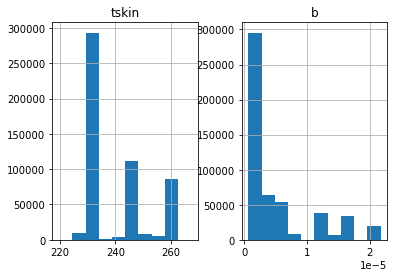

In [34]:
fig, axes = plt.subplots(ncols=2)
SUMup.hist('tskin',ax=axes[0])
SUMup.hist('b',ax=axes[1])

lat
-9999.0000    AxesSubplot(0.125,0.125;0.775x0.755)
-89.9333      AxesSubplot(0.125,0.125;0.775x0.755)
-88.5095      AxesSubplot(0.125,0.125;0.775x0.755)
-88.0022      AxesSubplot(0.125,0.125;0.775x0.755)
-86.8400      AxesSubplot(0.125,0.125;0.775x0.755)
                              ...                 
-69.8927      AxesSubplot(0.125,0.125;0.775x0.755)
-67.4440      AxesSubplot(0.125,0.125;0.775x0.755)
-67.0000      AxesSubplot(0.125,0.125;0.775x0.755)
-66.5880      AxesSubplot(0.125,0.125;0.775x0.755)
-66.4030      AxesSubplot(0.125,0.125;0.775x0.755)
Name: density, Length: 162, dtype: object

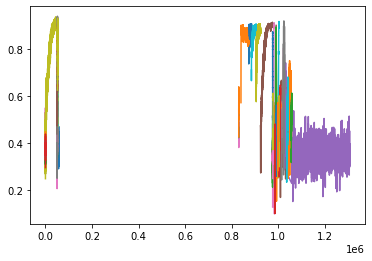

In [40]:
grouped = SUMup.groupby("lat")
grouped["density"].plot()

In [77]:
grouped.apply(lambda x: np.interp(0.83,x.density,x.midpoint_depth))

lat
-89.933300    118.424523
-88.509500     99.305000
-81.200000     38.695185
-79.614160     57.362488
-79.482778     70.558047
                 ...    
 76.544440      4.862429
 76.617000     59.918542
 77.238330      0.615000
 77.253300     69.213064
 80.000000     65.827429
Length: 69, dtype: float64